# Deep learning course project

## Introduction

This Jupyter Notebook implements a deep learning project using the BERT-GAN architecture for text classification. The project involves training a BERT-based generator and discriminator to perform text classification on a SemEval dataset.

## Setup and Environment

here we implemenet the needed libraries for this project

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import os

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"using {device} device")
print(f"using {torch.cuda.device_count()} GPUs!")

using cuda device
using 2 GPUs!


In [4]:
!pip install gdown
DOWNLOAD = True

In [7]:
!pip install git+https://github.com/adapter-hub/adapters.git
!pip install git+https://github.com/huggingface/peft

## Data Preparation

in this section we create the `Dataset` and `DataLoader` classes that we will be using for this project.

### Custom `Dataset` classes

This section defines two PyTorch datasets, `SemEvalDataset` and `MaskedSemEvalDataset`, tailored for handling SemEval-format datasets. The `SemEvalDataset` class initializes by optionally downloading the dataset, loading it from a specified path, and storing tokenized representations. The derived class, `MaskedSemEvalDataset`, extends the functionality by introducing a static mask for each sample based on a specified masking percentage. Both datasets enable efficient handling of raw text, labels, and tokenized representations.

In [49]:
import json
from torch.utils.data import Dataset

class SemEvalDataset(Dataset):
    def __init__(self, path, url=None, download=False):
        if download and url is not None:
            import gdown
            gdown.download(url, path, quiet=False, fuzzy=True)
        
        with open(path) as f:
            self.data = [json.loads(line) for line in f]
            
        self.K = len(set(sample['label'] for sample in self.data))
        self.path = path
        
        self.tokenized_data = []
        self.tokenizer = None
        self.token_opts = {}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.tokenizer is None:
            token = []
        elif idx < len(self.tokenized_data):
            token = self.tokenized_data[idx]
        else:
            token = self.tokenizer(self.data[idx]['text'], **self.token_opts)
            token.pop('token_type_ids', None)
            token['input_ids'] = token['input_ids'].squeeze(dim=0)
            token['attention_mask'] = token['attention_mask'].squeeze(dim=0)
        return self.data[idx]['text'], self.data[idx]['label'], token
    
    def tokenize_data(self, tokenizer, opts):
        from tqdm import tqdm
        self.tokenized_data = []
        self.tokenizer = tokenizer
        self.token_opts = opts
        for sample in tqdm(self.data, desc='Tokenizing data'):
            text = sample['text']
            token = tokenizer(text, **opts)
#             tokens = {k: v.squeeze(dim=0) for k, v in tokens.items()}
            token.pop('token_type_ids', None)
            token['input_ids'] = token['input_ids'].squeeze(dim=0)
            token['attention_mask'] = token['attention_mask'].squeeze(dim=0)
            self.tokenized_data.append(token)
        
    
class MaskedSemEvalDataset(SemEvalDataset):
    def __init__(self, path, url=None, download=False, mask_percentage=0.5):
        super().__init__(path, url, download)
        self.mask_percentage = mask_percentage
        # Generate a static mask
        self.masks = [1 if random.random() < self.mask_percentage else 0 for _ in range(len(self))]

    def __getitem__(self, idx):
        text, label, token = super().__getitem__(idx)
        mask = self.masks[idx]

        return text, label, mask, token

### Downloading the dataset

in this section we download the original dataset from the given repository.

equivalently one can just load the datasets via `pickle` from the later code sections.

In [5]:
# import gdown
train_url = 'https://drive.google.com/file/d/1k5LMwmYF7PF-BzYQNE2ULBae79nbM268/view?usp=drive_link'
test_url  = 'https://drive.google.com/file/d/1oh9c-d0fo3NtETNySmCNLUc6H1j4dSWE/view?usp=drive_link'

# train_url = test_url # JUST FOR NOW!!!!

train_path = 'train.json'
test_path = 'test.json'

full_dataset = SemEvalDataset(path=train_path, url=train_url, download=DOWNLOAD)
test_dataset = SemEvalDataset(path=test_path, url=test_url,  download=DOWNLOAD)

DOWNLOAD = False

TOKENIZE = True

num_samples = len(full_dataset)
train_size = int(0.95 * num_samples)
val_size = num_samples - train_size

K = full_dataset.K

print(f"Number of training examples: {train_size}")
print(f"Number of validation examples: {val_size}")
print(f"Number of test examples: {len(test_dataset)}")
print(f"Number of classes: {K}")

Downloading...
From (original): https://drive.google.com/uc?id=1k5LMwmYF7PF-BzYQNE2ULBae79nbM268
From (redirected): https://drive.google.com/uc?id=1k5LMwmYF7PF-BzYQNE2ULBae79nbM268&confirm=t&uuid=9594dc83-4ab0-4232-a7e9-9dc09d8e160a
To: /kaggle/working/train.json
100%|██████████| 155M/155M [00:00<00:00, 262MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1oh9c-d0fo3NtETNySmCNLUc6H1j4dSWE
To: /kaggle/working/test.json
100%|██████████| 4.93M/4.93M [00:00<00:00, 195MB/s]

Number of training examples: 67475
Number of validation examples: 3552
Number of test examples: 3000
Number of classes: 6


## Loading bert


This section defines a function `get_bert` that loads pre-trained `BERT` or `DistilBERT` models along with their respective tokenizers. 

It includes an option to extend the model using the PEFT (Parameter Efficient Fine-Tuning) technique, allowing for different PEFT methods like `lora`, `adalora`, or `IA3`. Additionally, the function can print the number of trainable parameters in the loaded model when the `print_params` parameter is set to True.

In [50]:
from transformers import BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params:.2e} || all params: {all_param:.2e} || trainable: {100 * trainable_params / all_param:.2f}%"
    )

def get_bert(model="bert", use_peft=False, print_params=False, peft_method="lora"):
    # Load pre-trained BERT
    if model == "bert":
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        bert = BertModel.from_pretrained('bert-base-uncased')
    elif model == "distil":
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
    else:
        raise ValueError("Invalid bert model")

    # Peft
    if use_peft:
        if peft_method == "lora":
            from peft import LoraConfig, LoraModel
            # Let's define the LoraConfig
            config = LoraConfig(
                r=16, lora_alpha=16, lora_dropout=0.01,
                bias="all",  task_type="SEQ_CLS", #target_modules=["q", "v"],,
            )
            bert = LoraModel(bert, config, "default")
        elif peft_method == "adalora":
            from peft import AdaLoraModel, AdaLoraConfig
            config = AdaLoraConfig(
                peft_type="ADALORA", task_type="SEQ_CLS", r=8, lora_alpha=32,# target_modules=["q", "v"],
                lora_dropout=0.01, adapter_name="default",
            )
            bert = AdaLoraModel(bert, config, "default")
        elif peft_method == "IA3":
            from peft import IA3Model, IA3Config
            config = IA3Config(
                peft_type="IA3", task_type="SEQ_CLS",
#                 target_modules=["k", "v", "w0"], feedforward_modules=["w0"],
            )
            bert = IA3Model(bert, config, "default")
            
    if print_params:
        print_trainable_parameters(bert)
    
    return bert, tokenizer

## Tokenization and Preprocessing

in this section we preprocess the data, as in tokenizing the dataset, and finding good parameters for things such as `MAX_LEN` for tokenization, and seeing the data distribution.

In [8]:
bert, tokenizer = get_bert(model="bert", use_peft=True, print_params=True, peft_method="IA3")

# Test
text = "Ali nourian save me"
tokens = tokenizer(text, return_tensors='pt')
outputs = bert(**tokens)

last_hidden_states = outputs.last_hidden_state
_, _, hidden_dim = last_hidden_states.shape
print("Last hidden states: ", last_hidden_states.shape)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

trainable params: 6.45e+04 || all params: 1.10e+08 || trainable: 0.06%
Last hidden states:  torch.Size([1, 7, 768])


### Data distribution

in this section we visualize the datasets length and class distribution.

In [9]:
from tqdm import tqdm
class_counts = [0] * K
sequence_lengths = []

for text, label, _ in tqdm(full_dataset):
    class_counts[label] += 1
#     num_tokens = len(tokenizer(text)['input_ids'])
    num_tokens = len(text.split(' '))
    sequence_lengths.append(num_tokens)

100%|██████████| 71027/71027 [00:01<00:00, 40574.39it/s]


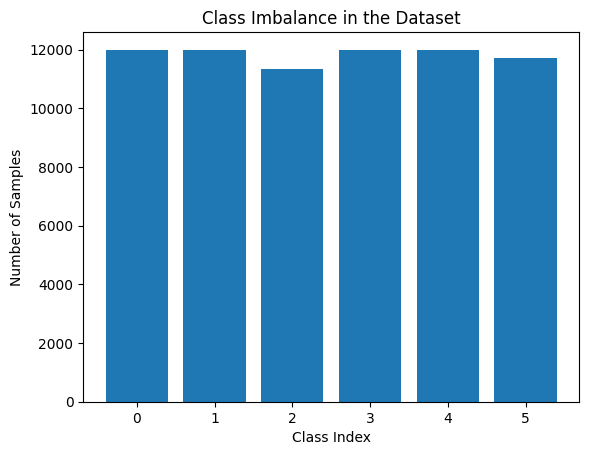

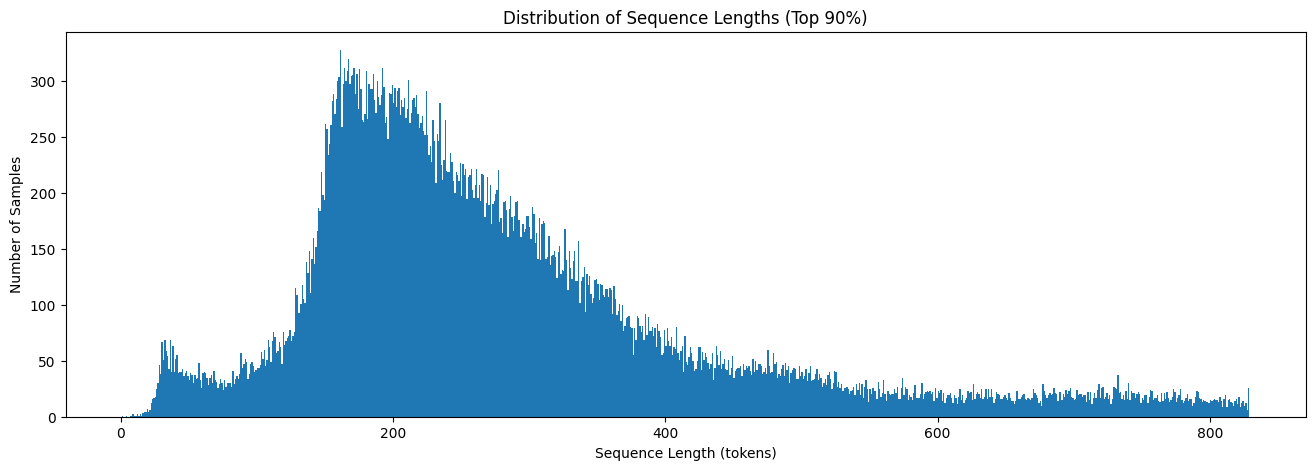

829.0

In [10]:
# Visualize class imbalance
plt.bar(range(K), class_counts, tick_label=range(K))
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')
plt.title('Class Imbalance in the Dataset')
plt.show()

# Calculate the threshold for the top 95%
threshold_length = np.percentile(sequence_lengths, 95)

# Filter sequence lengths
filtered_lengths = [length for length in sequence_lengths if length <= threshold_length]

# Plot the distribution of sequence lengths for the top 90%
plt.figure(figsize=(16,5))
plt.hist(filtered_lengths, bins=range(min(filtered_lengths), max(filtered_lengths) + 1, 1))
plt.xlabel('Sequence Length (tokens)')
plt.ylabel('Number of Samples')
plt.title('Distribution of Sequence Lengths (Top 90%)')
plt.show()

threshold_length


as we can see the data is pretty balanced class wise, so no special preprocessing is required, 
and by the length distribution and hardware limitations we choose `MAX_LEN = 256` to be adequite for classification.

### Data tokenization

with the found parameters, here we tokenize the dataset, one can also load saved tokenized datasets via `pickele`

In [11]:
MAX_LEN = 256

token_opts = {
    "return_tensors":'pt',
    "truncation": True,
    "padding": "max_length",
    "max_length": MAX_LEN
}

if TOKENIZE:
    full_dataset.tokenize_data(tokenizer, token_opts)
    test_dataset.tokenize_data(tokenizer, token_opts)

Tokenizing data: 100%|██████████| 3000/3000 [00:32<00:00, 92.83it/s] 


In [12]:
import pickle
with open( "full_dataset.p", "wb" ) as f:
    pickle.dump(full_dataset, f)
with open( "test_dataset.p", "wb" ) as f:
    pickle.dump(test_dataset, f)

In [51]:
import pickle

MAX_LEN = 256

token_opts = {
    "return_tensors":'pt',
    "truncation": True,
    "padding": "max_length",
    "max_length": MAX_LEN
}

with open( "full_dataset.p", "rb" ) as f:
    full_dataset = pickle.load(f)
with open( "test_dataset.p", "rb" ) as f:
    test_dataset = pickle.load(f)

### DataLoaders

here we define a simple function `get_loader` that helps us create dataloaders suitable for each task.

In [52]:
def get_loader(dataset, batch_size=24, shuffle=True):
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=os.cpu_count(), pin_memory=False
    )
num_samples = len(full_dataset)
train_size = int(0.95 * num_samples)
val_size = num_samples - train_size

# batch_size = 1 # online
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = get_loader(train_dataset)
test_loader  = get_loader(test_dataset)
val_loader   = get_loader(val_dataset)

#### Plotting results

In [53]:
def plot_results(metrics_by_percentage):
    plt.figure(figsize=(12, 6))

    percentages = list(metrics_by_percentage.keys())
    num_percentages = len(percentages)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    losses = []
    acc = []
    
    for i, (percentage, metrics) in enumerate(metrics_by_percentage.items(), 1):
        acc.append(metrics['accuracy'])
        losses.append(metrics['loss'])

    axs[0].plot(percentages, losses)
    axs[0].set_xlabel('Percentage')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss Over Percentages')

    axs[1].plot(percentages, acc)
    axs[1].set_xlabel('Percentage')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Test Accuracy Over Percentages')

    plt.tight_layout()
    plt.show()

# Example usage
# plot_results(metrics_by_percentage)


## Bert with Linear probing

In [14]:
bert, tokenizer = get_bert(model="bert")

# Test
text = "Ali nourian save me"
tokens = tokenizer(text, **token_opts)
outputs = bert(**tokens)
last_hidden_states = outputs.last_hidden_state
_, _, hidden_dim = last_hidden_states.shape

print("Last hidden states: ", last_hidden_states.shape)

trainable params: 6.93e+05 || all params: 1.10e+08 || trainable: 0.63%
Last hidden states:  torch.Size([1, 256, 768])


In [67]:
class BertLinear(nn.Module):
    def __init__(self, bert_model, num_labels, has_pooler=False):
        super(BertLinear, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(bert_model.config.hidden_size, num_labels)
        self.has_pooler = has_pooler

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        h = outputs.pooler_output if self.has_pooler else outputs.last_hidden_state[:, 0]
        logits = self.fc(h)
        return logits
    
bert_model = BertLinear(bert, K)
    
if torch.cuda.device_count() > 1:
    print("using", torch.cuda.device_count(), "GPUs!")
    bert_model = nn.DataParallel(bert_model)
    
bert_model = bert_model.to(device)
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bert_model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

bert_model

using 2 GPUs!


DataParallel(
  (module): BertLinear(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
        

In [ ]:
!mkdir linear_probe

In [ ]:
from tqdm import tqdm

# Define the percentages to use
train_percentages = [0.01, 0.05, 0.1, 0.5]

num_epochs = 3 # Same as the paper
print_every = 1

bert_metrics_by_percentage = {}

for train_percentage in train_percentages:
    print(f"""
=================================================================================================

                                Training on {100 * train_percentage} % of the dataset
    
=================================================================================================

    """)
    
    # Creating model
    bert_model = BertLinear(bert, K)
    
    if torch.cuda.device_count() > 1:
        print("using", torch.cuda.device_count(), "GPUs!")
        bert_model = nn.DataParallel(bert_model)

    bert_model = bert_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(bert_model.parameters(), lr=2e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    num_train_batches = int(len(train_loader) * train_percentage)
    
    metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    

    # batch_size = 1 # online
    train_size = len(train_dataset)
    num_train_batches = int(train_size * train_percentage)
    train_loader_percented, _ = random_split(train_dataset, [num_train_batches, train_size - num_train_batches])
    train_loader_percented = get_loader(train_loader_percented)
    
    # Train the model
    for epoch in range(num_epochs):
        bert_model.train()

        # Training
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels, token in tqdm(train_loader_percented, desc=f'Train - epoch {epoch + 1}/{num_epochs}'):
            token, labels = token.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = bert_model(**token)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            

        train_acc = correct_train / total_train

        # Validation
        bert_model.eval()
        val_loss = 0.0
        total_val = 0
        correct_val = 0
        with torch.no_grad():
            for inputs, labels, token in tqdm(val_loader, desc=f'Validation - epoch {epoch + 1}/{num_epochs}'):
                token, labels = token.to(device), labels.to(device)
                outputs = bert_model(**token)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = correct_val / total_val

        metrics['train_loss'].append(train_loss / num_train_batches)
        metrics['val_loss'].append(val_loss / len(val_loader))
        metrics['train_acc'].append(train_acc)
        metrics['val_acc'].append(val_acc)

        scheduler.step()

        if (epoch + 1) % print_every == 0:
            print(f"""
            Training loss: {metrics['train_loss'][-1]:.4f}, Validation loss: {metrics['val_loss'][-1]:.4f},
            Training accuracy: {metrics['train_acc'][-1] * 100:.2f}%, Validation accuracy: {metrics['val_acc'][-1] * 100:.2f}%
            """)
#                 Model is too large, we won't save it
    # Save model checkpoint
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': bert_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'metrics': metrics,
    }
    torch.save(checkpoint, f'./linear_probe/model_checkpoint_{int(train_percentage * 100)}%.pth')
    # Save metrics for the current percentage
    bert_metrics_by_percentage[f"{int(train_percentage * 100)}%"] = metrics

In [ ]:
import matplotlib.pyplot as plt

percentages = list(bert_metrics_by_percentage.keys())

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
axs[0].plot(percentages, [metrics['train_loss'][-1] for metrics in bert_metrics_by_percentage.values()], label='Train Loss')
axs[0].plot(percentages, [metrics['val_loss'][-1] for metrics in bert_metrics_by_percentage.values()], label='Validation Loss')
axs[0].set_title("Loss as a function of dataset percentage")
axs[0].set_xlabel('Percentage of the dataset')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation accuracy
axs[1].plot(percentages, [metrics['train_acc'][-1] * 100 for metrics in bert_metrics_by_percentage.values()], label='Train Accuracy')
axs[1].plot(percentages, [metrics['val_acc'][-1] * 100 for metrics in bert_metrics_by_percentage.values()], label='Validation Accuracy')
axs[1].set_title("Accuracy as a function of dataset percentage")
axs[1].set_xlabel('Percentage of the dataset')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
percentages = [0.01, 0.05, 0.1, 0.5]
metrics_by_percentage = {}
for percentage in percentages:
    # Define model
    bert_model = BertLinear(bert, K)
    
    if torch.cuda.device_count() > 1:
        print("using", torch.cuda.device_count(), "GPUs!")
        bert_model = nn.DataParallel(bert_model)

    bert_model = bert_model.to(device)

    metrics = {'loss': [], 'accuracy': []}

    # Load model
    path = f'./linear_probe/model_checkpoint_{int(percentage * 100)}%.pth'
    checkpoint = torch.load(path)
    bert_state_dict = checkpoint['model_state_dict']
    bert_model.load_state_dict(bert_state_dict)
    # Testing
    bert_model.eval()
    test_loss = 0.0
    all_predicts_test = np.array([])
    all_labels_test = np.array([])
    with torch.no_grad():
        for inputs, labels, token in tqdm(test_loader, desc=f'Testing'):
            token, labels = token.to(device), labels.to(device)
            outputs = bert_model(**token)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            all_predicts_test = np.append(all_predicts_test, predicted.detach().cpu().numpy())
            all_labels_test = np.append(all_labels_test, labels.detach().cpu().numpy())

    test_acc = (all_predicts_test == all_labels_test).sum().item() / len(all_predicts_test)

    metrics['loss'].append(test_loss / len(test_loader))
    metrics['accuracy'].append(test_acc)
    
    metrics_by_percentage[f"{int(percentage * 100)}%"] = metrics

In [ ]:
plot_results(metrics_by_percentage)

## Using adapters

In [ ]:
from transformers import BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel
# add adapters to BERT for classification task
from adapters import AutoAdapterModel


def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

def get_bert(model="bert", use_peft=False, print_params=False, peft_method="lora", num_labels=None):
    # Load pre-trained BERT
    if num_labels == None:
        if model == "bert":
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            bert = BertModel.from_pretrained('bert-base-uncased')
        elif model == "distil":
            tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
            bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        else:
            raise ValueError("Invalid bert model")

        # Peft
        if use_peft:
            if peft_method == "lora":
                from peft import LoraConfig, LoraModel
                # Let's define the LoraConfig
                config = LoraConfig(
                    r=16, lora_alpha=16, lora_dropout=0.01,
                    bias="all",  task_type="SEQ_CLS", #target_modules=["q", "v"],,
                )
                bert = LoraModel(bert, config, "default")
            elif peft_method == "adalora":
                from peft import AdaLoraModel, AdaLoraConfig
                config = AdaLoraConfig(
                    peft_type="ADALORA", task_type="SEQ_CLS", r=8, lora_alpha=32,# target_modules=["q", "v"],
                    lora_dropout=0.01, adapter_name="default",
                )
                bert = AdaLoraModel(bert, config, "default")
            elif peft_method == "IA3":
                from peft import IA3Model, IA3Config
                config = IA3Config(
                    peft_type="IA3", task_type="SEQ_CLS",
    #                 target_modules=["k", "v", "w0"], feedforward_modules=["w0"],
                )
                bert = IA3Model(bert, config, "default")
    else:
        # load pre-trained BERT model
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        bert = AutoAdapterModel.from_pretrained("bert-base-uncased")
        # By default, this model doesn’t have any heads yet. We add a new one in the next step
        bert.add_classification_head("mrpc", num_labels = num_labels)
        # add a new adapter with proper config 
        bert.add_adapter("mrpc", config="double_seq_bn")
        bert.set_active_adapters("mrpc")
        # Enable adapter training
        bert.train_adapter("mrpc")
        bert.set_active_adapters("mrpc")
    if print_params:
        print_trainable_parameters(bert)
    
    return bert, tokenizer

In [ ]:
bert_model = get_bert(num_labels=K)
print_trainable_parameters(bert_model)

In [ ]:
if torch.cuda.device_count() > 1:
    print("using", torch.cuda.device_count(), "GPUs!")
    bert_model = nn.DataParallel(bert_model)
    
bert_model = bert_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-4) # change lr
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) #CosineAnnealingLR

bert_model

In [ ]:
from tqdm import tqdm
import time
# Define the percentages to use
train_percentages = [0.01, 0.05, 0.1, 0.5]

num_epochs = 3 # Same as the paper + 1 (adapters need more epoches)
print_every = 1

#bert_model = bert_model.to(device)
bert_metrics_by_percentage = {}

for train_percentage in train_percentages:
    print(f"""
=================================================================================================

                                Training on {100 * train_percentage} % of the dataset
    
=================================================================================================

    """)
    
    num_train_batches = int(len(train_loader) * train_percentage)
    
    metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    bert_model = get_bert(num_labels=K)
    if torch.cuda.device_count() > 1:
        print("using", torch.cuda.device_count(), "GPUs!")
        bert_model = nn.DataParallel(bert_model)
    bert_model = bert_model.to(device)
    
    # Train the model
    for epoch in range(num_epochs):
        
        # Freeze all parameters in BERT and only fine-tune the adapter's parameters
        bert_model.train_adapter("mrpc")
        

        # Training
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        batch_idx = 0
        for inputs, labels, token in tqdm(train_loader, desc=f'Train - epoch {epoch + 1}/{num_epochs}'):
            start_time = time.time()
            batch_idx += 1
            if batch_idx >= num_train_batches:
                break
            encoded = tokenizer(inputs, **token_opts) if not TOKENIZE else token
            encoded.pop('token_type_ids', None)
            encoded, labels = encoded.to(device), labels.to(device)
            encoded = dict([(k, v.squeeze(dim=1)) for (k, v) in encoded.items()])
            optimizer.zero_grad()
            outputs = bert_model(**encoded)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.logits, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_acc = correct_train / total_train

        # Validation
        bert_model.eval()
        val_loss = 0.0
        total_val = 0
        correct_val = 0
        with torch.no_grad():
            for inputs, labels, token in tqdm(val_loader, desc=f'Validation - epoch {epoch + 1}/{num_epochs}'):
                encoded = tokenizer(inputs, **token_opts) if not TOKENIZE else token
                encoded.pop('token_type_ids')
                encoded, labels = encoded.to(device), labels.to(device)
                encoded = dict([(k, v.squeeze(dim=1)) for (k, v) in encoded.items()])
                outputs = bert_model(**encoded)
                loss = criterion(outputs.logits, labels)

                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.logits, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = correct_val / total_val

        metrics['train_loss'].append(train_loss / num_train_batches)
        metrics['val_loss'].append(val_loss / len(val_loader))
        metrics['train_acc'].append(train_acc)
        metrics['val_acc'].append(val_acc)

        scheduler.step()

        if (epoch + 1) % print_every == 0:
            print(f"""
            Training loss: {metrics['train_loss'][-1]:.4f}, Validation loss: {metrics['val_loss'][-1]:.4f},
            Training accuracy: {metrics['train_acc'][-1] * 100:.2f}%, Validation accuracy: {metrics['val_acc'][-1] * 100:.2f}%
            """)
    path = f'./bert_model_adapters_checkpoint_{int(train_percentage * 100)}%.pth'
    #bert_model.save_adapter(path, "mrpc", with_head=True)
    #with open(path, 'wb') as handle:
     #   pickle.dump(bert_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Save model checkpoint
    checkpoint = {
         'epoch': epoch + 1,
         'model_state_dict': bert_model.state_dict(),
         'optimizer_state_dict': optimizer.state_dict(),
         'scheduler_state_dict': scheduler.state_dict(),
         'metrics': metrics,
    }
    torch.save(checkpoint, path)
    
        
    # Save metrics for the current percentage
    bert_metrics_by_percentage[f"{int(train_percentage * 100)}%"] = metrics

In [ ]:
import matplotlib.pyplot as plt

percentages = list(bert_metrics_by_percentage.keys())

def plot_results(metrics_by_percentage):
    plt.figure(figsize=(12, 6))

    percentages = list(metrics_by_percentage.keys())
    num_percentages = len(percentages)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    losses = []
    acc = []
    
    for i, (percentage, metrics) in enumerate(metrics_by_percentage.items(), 1):
        acc.append(metrics['accuracy'])
        losses.append(metrics['loss'])

    axs[0].plot(percentages, losses)
    axs[0].set_xlabel('Percentage')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss Over Percentages')

    axs[1].plot(percentages, acc)
    axs[1].set_xlabel('Percentage')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Test Accuracy Over Percentages')

    plt.tight_layout()
    plt.show()



fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
axs[0].plot(percentages, [metrics['train_loss'][-1] for metrics in bert_metrics_by_percentage.values()], label='Train Loss')
axs[0].plot(percentages, [metrics['val_loss'][-1] for metrics in bert_metrics_by_percentage.values()], label='Validation Loss')
axs[0].set_title("Loss as a function of dataset percentage")
axs[0].set_xlabel('Percentage of the dataset')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation accuracy
axs[1].plot(percentages, [metrics['train_acc'][-1] * 100 for metrics in bert_metrics_by_percentage.values()], label='Train Accuracy')
axs[1].plot(percentages, [metrics['val_acc'][-1] * 100 for metrics in bert_metrics_by_percentage.values()], label='Validation Accuracy')
axs[1].set_title("Accuracy as a function of dataset percentage")
axs[1].set_xlabel('Percentage of the dataset')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
percentages = [0.01, 0.05, 0.1, 0.5]
metrics_by_percentage = {}
for percentage in percentages:
    # Define model
    # Load model
    path = f'./bert_model_adapters_checkpoint_{int(percentage * 100)}%.pth'
    checkpoint = torch.load(path)
    bert_state_dict = checkpoint['model_state_dict']
    bert_model.load_state_dict(bert_state_dict)
    
    if torch.cuda.device_count() > 1:
        print("using", torch.cuda.device_count(), "GPUs!")
        bert_model = nn.DataParallel(bert_model)

    bert_model = bert_model.to(device)

    metrics = {'loss': [], 'accuracy': []}

    # Testing
    bert_model.eval()
    test_loss = 0.0
    all_predicts_test = np.array([])
    all_labels_test = np.array([])
    with torch.no_grad():
        for inputs, labels, token in tqdm(test_loader, desc=f'Testing'):
            token, labels = token.to(device), labels.to(device)
            outputs = bert_model(**token)
            loss = criterion(outputs.logits, labels)

            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.logits, 1)
            all_predicts_test = np.append(all_predicts_test, predicted.detach().cpu().numpy())
            all_labels_test = np.append(all_labels_test, labels.detach().cpu().numpy())

    test_acc = (all_predicts_test == all_labels_test).sum().item() / len(all_predicts_test)

    metrics['loss'].append(test_loss / len(test_loader))
    metrics['accuracy'].append(test_acc)
    
    metrics_by_percentage[f"{int(percentage * 100)}%"] = metrics
plot_results(metrics_by_percentage)

## BertGan Implementation

in this section we implement the `BertGan` architechture that tries to learn the task adversially, including a generator model that helps our typical discriminator model in classification, in a `GAN` fashion.

## G1 generator

### FF_Generator Class

this class implements the `G1` model specified in the paper, this is a simple `MLP` model, that tries to imitate the manifolds generated by the real data.

In [54]:
class FF_Generator(nn.Module):
    def __init__(self, in_features, hidden_dim=256, out_features=768, dropout_prob=0.15):
        super(FF_Generator, self).__init__()
        # Parameters
        self.latent_size = in_features
        self.hidden_size = hidden_dim
        self.out_features = out_features
        # Layers
        self.hidden = nn.Linear(in_features=in_features, out_features=hidden_dim)
        self.act = nn.LeakyReLU(negative_slope=0.2)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.head = nn.Linear(in_features=hidden_dim, out_features=out_features)
        
    def forward(self, x):
        # hidden layer
        h = self.act(self.hidden(x))
        h = self.dropout(h)
        # output layer
        y = self.head(h)
        
        return y

# Testing
latent_size = 100
generator = FF_Generator(in_features=latent_size)

num_samples = 5
random_latents = torch.randn((num_samples, latent_size))

generated_samples = generator(random_latents)

print(generated_samples.shape)

torch.Size([5, 768])


### Discriminator class

this class is a simple Feed-Forward architechture for our discriminator, which does the classification task on the given data generated by either the generator or the bert model processing real data, trying to classify the data in a supervised way, while learning the representations adversially in an unsupervised manner.

In [55]:
class Discriminator(nn.Module):
    def __init__(self, k, in_features, hidden_dims=[512, 256, 128], dropout_prob=0.15):
        super(Discriminator, self).__init__()
        # Parameters
        self.k = k
        self.in_feature_size = in_features

        # Define the discriminator layers based on hidden_dims
        layers = []
        layers.append(nn.Dropout(p=dropout_prob))
        for i in range(len(hidden_dims)):
            layers.extend([
                nn.Linear(in_features=in_features if i == 0 else hidden_dims[i-1], out_features=hidden_dims[i]),
                nn.LeakyReLU(negative_slope=0.2),
                nn.Dropout(p=dropout_prob)
            ])

        # Sequential discriminator layers
        self.discriminator = nn.Sequential(*layers)

        # Head layer
        self.head = nn.Linear(in_features=hidden_dims[-1], out_features=k + 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, return_logits=True):
        # Forward pass through the sequential layers
        h = self.discriminator(x)
        # Output layer
        logits = self.head(h)
        # Softmax
        probs = self.softmax(logits)

        if return_logits:
            return probs, logits, h
        return probs, h

# Testing
k_value = K
in_features = generator.out_features
discriminator = Discriminator(k=k_value, in_features=in_features)

batch_size = 5
input_data = torch.randn((batch_size, in_features))

probs, logits, hidden_states = discriminator(input_data)

print("Probs:", probs.shape)
print("Logits:", logits.shape)
print("Hidden States:", hidden_states.shape)

Probs: torch.Size([5, 7])
Logits: torch.Size([5, 7])
Hidden States: torch.Size([5, 128])


### BertGan implementation

this model is just combining the `generator` and `discriminator` along with the `bert` model, and helps us in training the bertGan, as it computes the neccesary losses, and performing the forward pass alongside adverserial generation.

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BertGan(nn.Module):
    def __init__(self, Generator, Discriminator, Bert, fast_gen_grad=False, has_pooler=False, no_grad_bert=False):
        super(BertGan, self).__init__()
        
        self.generator = Generator
        self.discriminator = Discriminator
        self.bert = Bert
        
        self.k = self.discriminator.k
        self.epsilon = 1e-8
        
        self.gen_log_grad = fast_gen_grad
        
        self.has_pooler = has_pooler
        self.no_grad_bert = no_grad_bert

    def forward(self, inputs, z=None, labels=None, label_mask=None):
        # Bert real data forward pass
        bert_outputs = self.bert(**inputs) 
        x_r = bert_outputs.pooler_output if self.has_pooler else bert_outputs.last_hidden_state[:, 0]
        if self.no_grad_bert:
            x_r = x_r.detach()
            
        # Discriminator forward pass on real data
        D_real_prob, D_real_logits, D_real_features = self.discriminator(x_r)
        
        # Supervised loss
        real_logits = D_real_logits[:, :-1]
        real_prob   = F.softmax(real_logits, dim=-1)
        d_loss_sup = 0
        if labels is not None:
            if label_mask is None:
                label_mask = torch.ones_like(labels)
            ce = F.cross_entropy(real_logits, labels, reduction='none')
            masked_ce = ce * label_mask
            d_loss_sup = masked_ce.sum() / max(label_mask.sum(), 1) 
        
        # Inference mode
        if z is None:
            # If latent (z) is None, skip the generator and set g_loss to None
            d_loss = -torch.mean(
                torch.log(1 - D_real_prob[:, -1] + self.epsilon)
            ) + d_loss_sup
            return {
                'probs': real_prob,
                'logits': real_logits,
                'd_loss': d_loss,
                'g_loss': None,
            }

        # Generator forward pass
        x_g = self.generator(z)

        # Discriminator forward pass on fake data
        D_fake_prob, D_fake_logits, D_fake_features = self.discriminator(x_g)

        # Discriminator loss
        # Unsupervised loss
        d_loss_unsup = -torch.mean(
            torch.log(1 - D_real_prob[:, -1] + self.epsilon)
        ) - torch.mean(
            torch.log(D_fake_prob[:, -1] + self.epsilon)
        )

        d_loss = d_loss_unsup + d_loss_sup

        # Generator loss
        g_loss_unsup = -torch.mean(
            torch.log(1 - D_fake_prob[:, -1] + self.epsilon) 
            if not self.gen_log_grad else
            - torch.log(D_fake_prob[:, -1] + self.epsilon)
        )
        g_loss_feature_match = torch.mean(
            (torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0)) ** 2
        )

        g_loss = g_loss_unsup + g_loss_feature_match
        
        output = {
            'probs': real_prob,
            'logits': real_logits,
            'd_loss': d_loss,
            'g_loss': g_loss,
        }

        return output

## Adverserial training

the adverserial training step is defined as follows:

$$\quad L_{\mathcal{D}}=L_{\mathcal{D}_{\text {sup. }}}+L_{\mathcal{D}_{\text {unsup. }}}$$
$$
\begin{gather*}
L_{\mathcal{D}_{\text {sup. }}}  =-\mathbb{E}_{x, y \sim p_d} \log \left[p_{\mathrm{m}}(\hat{y}=y \mid x, y \in(1, \ldots, k))\right] \\
L_{\mathcal{D}_{\text {unsup. }}}  =-\mathbb{E}_{x \sim p_d} \log \left[1-p_{\mathrm{m}}(\hat{y}=y \mid x, y=k+1)\right] -\mathbb{E}_{x \sim \mathcal{G}} \log \left[p_{\mathrm{m}}(\hat{y}=y \mid x, y=k+1)\right] \\
\rightarrow  L_{\mathcal{D}_{\text {unsup. }}}  =-\mathbb{E}_{x \sim p_d} [\log (\mathcal{D}(x))] -\mathbb{E}_{x \sim \mathcal{G}} 
[\log (1-\mathcal{D}(x))]
\end{gather*}
$$

$$L_{\mathcal{G}_{\text {unsup. }}}=-\mathbb{E}_{x \sim \mathcal{G}} 
\log \left[1-p_m(\hat{y}=y \mid x, y=k+1)\right]$$
$$ 
L_{\mathcal{G}_{\text {feature matching }}} = \frac{1}{\text{hidden\_dim}}||\mathbb{E}_{x \sim p_d} f(x) 
- \mathbb{E}_{x \sim \mathcal{G}} f(x) ||_2^2
$$

this block simply tests the defined bertGan model.

In [57]:
# Test
bert, tokenizer = get_bert()
bert_gan = BertGan(Generator=generator, Discriminator=discriminator, Bert=bert)

batch_size = 5
latent_batch_size = 10
random_latents = torch.randn((latent_batch_size, latent_size))
random_inputs = tokenizer(
    ["ali nourian save me"] * batch_size, return_tensors='pt', truncation=True, padding="max_length"
)
random_labels = torch.randint(0, discriminator.k, (batch_size,))
random_mask   = torch.randint(0, 2, (batch_size,))

# Train
output = bert_gan(random_inputs, random_latents, random_labels, random_mask)
# Inference
output_inf = bert_gan(random_inputs)

print("Training:\n")
print("Discriminator Loss:", output['d_loss'].item())
print("Generator Loss:", output['g_loss'].item())
print("Logits:", output['logits'].shape)
print("Probabilities:", output['probs'].shape)
print("\nInference:\n")
print("Discriminator Loss:", output_inf['d_loss'].item())
print("Generator Loss:", output_inf['g_loss'])
print("Logits:", output_inf['logits'].shape)
print("Probabilities:", output_inf['probs'].shape)

# Testing good grads
output['g_loss'].backward(retain_graph=True)
output['d_loss'].backward()

Training:

Discriminator Loss: 3.8696823120117188
Generator Loss: 0.1505683958530426
Logits: torch.Size([5, 6])
Probabilities: torch.Size([5, 6])

Inference:

Discriminator Loss: 0.15020646154880524
Generator Loss: None
Logits: torch.Size([5, 6])
Probabilities: torch.Size([5, 6])


### model implementation

in this part we simply visualize what the model looks like.

In [58]:
latent_size = 100

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

generator = FF_Generator(
    in_features=latent_size, hidden_dim=hidden_dim, out_features=hidden_dim
)
discriminator = Discriminator(
    k=K, in_features=hidden_dim
)
bertGan = BertGan(
    generator, discriminator, bert, fast_gen_grad=True
)

#models parameters
bert_vars = [i for i in bertGan.bert.parameters()]
d_vars = bert_vars + [v for v in bertGan.discriminator.parameters()]
g_vars = bertGan.generator.parameters()

#optimizer
d_lr = 5e-4
g_lr = 5e-4
n_critic = 5
dis_optimizer = optim.AdamW(d_vars, lr=d_lr)
gen_optimizer = optim.AdamW(g_vars, lr=g_lr) 

if torch.cuda.device_count() > 1: # Since we are using different ootimizers
    print("using", torch.cuda.device_count(), "GPUs!")
    bertGan.bert = nn.DataParallel(bertGan.bert)
    bertGan.discriminator = nn.DataParallel(bertGan.discriminator)
    bertGan.generator = nn.DataParallel(bertGan.generator)
    
bertGan = bertGan.to(device)

bertGan

using 2 GPUs!


BertGan(
  (generator): DataParallel(
    (module): FF_Generator(
      (hidden): Linear(in_features=100, out_features=768, bias=True)
      (act): LeakyReLU(negative_slope=0.2)
      (dropout): Dropout(p=0.15, inplace=False)
      (head): Linear(in_features=768, out_features=768, bias=True)
    )
  )
  (discriminator): DataParallel(
    (module): Discriminator(
      (discriminator): Sequential(
        (0): Dropout(p=0.15, inplace=False)
        (1): Linear(in_features=768, out_features=512, bias=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.15, inplace=False)
        (4): Linear(in_features=512, out_features=256, bias=True)
        (5): LeakyReLU(negative_slope=0.2)
        (6): Dropout(p=0.15, inplace=False)
        (7): Linear(in_features=256, out_features=128, bias=True)
        (8): LeakyReLU(negative_slope=0.2)
        (9): Dropout(p=0.15, inplace=False)
      )
      (head): Linear(in_features=128, out_features=7, bias=True)
      (softmax): Softmax

### BertGan training

this function implement the training procedure of the BertGan model

In [59]:
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import time

def train_bertgan(
    bertgan, 
    dis_optimizer, gen_optimizer, bert_optimizer,
    masked_train_loader, val_loader, 
    dis_scheduler=None, gen_scheduler=None, bert_scheduler=None,
    num_epochs=3, print_every=1, c=1, n_critic=5, latent_dim=100, spherical=True):

    metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        bertgan.train()

        if gen_scheduler is not None:
            gen_scheduler.step()
        if dis_scheduler is not None:
            dis_scheduler.step()
        if bert_scheduler is not None:
            bert_scheduler.step()
            print(f"Current bert lr: {bert_scheduler.get_last_lr()}")
        
        # Training
        train_loss = 0.0
        batch_idx = 0
        all_predicts_train = np.array([])
        all_labels_train = np.array([])
        
        for inputs, labels, mask, token in tqdm(masked_train_loader, desc=f'Train - epoch {epoch + 1}/{num_epochs}'):
            batch_idx += 1
            token, labels, mask = token.to(device), labels.to(device), mask.to(device)
            z = torch.zeros(train_loader.batch_size, latent_dim, device=device).uniform_(0, 1)
            if spherical:
                theta = 0
            
            bertGan.bert.zero_grad()
            bertGan.discriminator.zero_grad()
            
            outputs = bertgan(token, z=z, labels=labels, label_mask=mask)
            d_loss = outputs['d_loss']
            g_loss = outputs['g_loss']
            
            dis_optimizer.zero_grad()
            gen_optimizer.zero_grad()
            
            # retain_graph=True is required since the underlying graph will be deleted after backward
            g_loss.backward(retain_graph=True)
            d_loss.backward()
            
            # Lipchitz continious
#             clip_grad_norm_(bertgan.discriminator.parameters(), c)
#             clip_grad_norm_(bertgan.generator.parameters(), c)
            if (batch_idx + 1) % n_critic == 0:
                gen_optimizer.step() 
            dis_optimizer.step()
            bert_optimizer.step()

            train_loss += g_loss.item() + d_loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs['probs'], 1)
            all_predicts_train = np.append(all_predicts_train, predicted.detach().cpu().numpy())
            all_labels_train = np.append(all_labels_train, labels.detach().cpu().numpy())

        train_acc = (all_predicts_train == all_labels_train).sum().item() / len(all_predicts_train)

        # Validation
        bertgan.eval()
        val_loss = 0.0
        all_predicts_val = np.array([])
        all_labels_val = np.array([])
        with torch.no_grad():
            for inputs, labels, _, token in tqdm(masked_val_loader, desc=f'Validation - epoch {epoch + 1}/{num_epochs}'):
                token, labels = token.to(device), labels.to(device)
                outputs = bertgan(token, labels=labels)
                loss = outputs['d_loss']

                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs['probs'], 1)
                all_predicts_val = np.append(all_predicts_val, predicted.detach().cpu().numpy())
                all_labels_val = np.append(all_labels_val, labels.detach().cpu().numpy())

        val_acc = (all_predicts_val == all_labels_val).sum().item() / len(all_predicts_val)

        metrics['train_loss'].append(train_loss / len(train_loader))
        metrics['val_loss'].append(val_loss / len(val_loader))
        metrics['train_acc'].append(train_acc)
        metrics['val_acc'].append(val_acc)

        if (epoch + 1) % print_every == 0:
            print(f"""
            Training loss: {metrics['train_loss'][-1]:.4f}, Validation loss: {metrics['val_loss'][-1]:.4f},
            Training accuracy: {metrics['train_acc'][-1] * 100:.2f}%, Validation accuracy: {metrics['val_acc'][-1] * 100:.2f}%
            """)

    return metrics

In [21]:
!mkdir bertgan_G1_with_grad

In [63]:
def get_masked_loader(path, percentage, full_dataset, train_size, val_size, batch_size=128):
    masked_full_dataset = MaskedSemEvalDataset(path, mask_percentage=percentage)
    masked_full_dataset.tokenized_data = full_dataset.tokenized_data
    masked_full_dataset.tokenizer = full_dataset.tokenizer
    masked_full_dataset.data = full_dataset.data
    masked_train_dataset, masked_val_dataset = random_split(masked_full_dataset, [train_size, val_size])
    masked_train_loader = get_loader(masked_train_dataset, batch_size=batch_size)
    masked_val_loader = get_loader(masked_val_dataset, batch_size=batch_size)
    
    return masked_train_loader, masked_val_loader

### Training loop

in this loop we create a new bertGan model for each percentage of dataset visible for the model, and then return the metrics of the training loop in the end, saving the metrics by percentage for future plots.

In [ ]:
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

percentages = [0.01, 0.05, 0.1, 0.5]
metrics_by_percentage = {}

for percentage in percentages:
    print(f"""
=================================================================================================

                                Training on {100 * percentage} % of the dataset
    
=================================================================================================

    """)
    # Define model
    bert, _ = get_bert(model="distil")

    generator = FF_Generator(
        in_features=latent_size, hidden_dim=hidden_dim, out_features=hidden_dim
    )
    discriminator = Discriminator(
        k=K, in_features=hidden_dim
    )
    bertGan = BertGan(
        generator, discriminator, bert, fast_gen_grad=False,# no_grad_bert=True,
    )

    if torch.cuda.device_count() > 1: # Since we are using different ootimizers
        print("using", torch.cuda.device_count(), "GPUs!")
        bertGan.bert = nn.DataParallel(bertGan.bert)
        bertGan.discriminator = nn.DataParallel(bertGan.discriminator)
        bertGan.generator = nn.DataParallel(bertGan.generator)
        
    bertGan = bertGan.to(device)

    # hyper-parameters
    d_lr = 5e-4
    g_lr = 5e-4
    batch_size = 128
    num_epochs = 3
    warmup_ratio = 0.1
    num_training_steps = int(train_size / batch_size * num_epochs)
    num_warmup_steps   = int(num_training_steps * warmup_ratio)
    
    #optimizer
    bert_optimizer = optim.AdamW(bertGan.bert.parameters(), lr=d_lr) 
    dis_optimizer = optim.AdamW(bertGan.discriminator.parameters(), lr=d_lr)
    gen_optimizer = optim.AdamW(bertGan.generator.parameters(), lr=g_lr) 
    
    #scheduler
    bert_scheduler = get_linear_schedule_with_warmup(
        bert_optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps,
    )
    dis_scheduler = None
    gen_scheduler = None
    
    # Training
    masked_train_loader, masked_val_loader = get_masked_loader(
        train_path, percentage, full_dataset, train_size, val_size, batch_size=batch_size,
    )
    metrics = train_bertgan(
        bertGan, 
        dis_optimizer, gen_optimizer, bert_optimizer,
        dis_scheduler=dis_scheduler, gen_scheduler=gen_scheduler, bert_scheduler=bert_scheduler,
        masked_train_loader=masked_train_loader, val_loader=masked_val_loader, n_critic=1, num_epochs=num_epochs,
    )
    
    # Save model checkpoint
    checkpoint = {
        'percentage': percentage,
        'model_state_dict': bertGan.state_dict(),
        'metrics': metrics,
        'disc_optimizer_state_dict': dis_optimizer.state_dict(),
        'gen_optimizer_state_dict': gen_optimizer.state_dict(),
    }
    
    torch.save(checkpoint, f'./bertgan_G1_with_grad/model_checkpoint_{int(percentage * 100)}%.pth')
    metrics_by_percentage[f"{int(percentage * 100)}%"] = metrics

In [ ]:
import matplotlib.pyplot as plt

percentages = list(metrics_by_percentage.keys())

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
axs[0].plot(percentages, [metrics['train_loss'][-1] for metrics in metrics_by_percentage.values()], label='Train Loss')
axs[0].plot(percentages, [metrics['val_loss'][-1] for metrics in metrics_by_percentage.values()], label='Validation Loss')
axs[0].set_title("Loss as a function of dataset percentage")
axs[0].set_xlabel('Percentage of the dataset')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation accuracy
axs[1].plot(percentages, [metrics['train_acc'][-1] * 100 for metrics in metrics_by_percentage.values()], label='Train Accuracy')
axs[1].plot(percentages, [metrics['val_acc'][-1] * 100 for metrics in metrics_by_percentage.values()], label='Validation Accuracy')
axs[1].set_title("Accuracy as a function of dataset percentage")
axs[1].set_xlabel('Percentage of the dataset')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()

plt.tight_layout()
plt.show()

In [20]:
train_path = '/kaggle/working/train.json'

In [67]:
import gc
torch.cuda.empty_cache()
del bertGan , bert, g_vars, d_vars
gc.collect()

5647

## Testing G1

here we use the test dataset and check the accuracy of each trained model, with respect the percentage of dataset used.

In [ ]:
from tqdm import tqdm
percentages = [0.01, 0.05, 0.1, 0.5]
acc_per_percent = {}
for percentage in percentages:
    # Define model
    bert, _ = get_bert(model="distil")

    generator = FF_Generator(
        in_features=latent_size, hidden_dim=hidden_dim, out_features=hidden_dim
    )
    discriminator = Discriminator(
        k=K, in_features=hidden_dim
    )
    bertgan = BertGan(
        generator, discriminator, bert, fast_gen_grad=False,# no_grad_bert=True,
    )

    if torch.cuda.device_count() > 1: # Since we are using different ootimizers
        print("using", torch.cuda.device_count(), "GPUs!")
        bertgan.bert = nn.DataParallel(bertgan.bert)
        bertgan.discriminator = nn.DataParallel(bertgan.discriminator)
        bertgan.generator = nn.DataParallel(bertgan.generator)
    
    metrics = {'loss': [], 'accuracy': []}
    bertgan = bertgan.to(device)
    # Load model
    path = f'./bertgan_G1_with_grad/model_checkpoint_{int(percentage * 100)}%.pth'
    checkpoint = torch.load(path)
    bertgan_state_dict = checkpoint['model_state_dict']
    bertgan.load_state_dict(bertgan_state_dict)
    # Testing
    bertgan.eval()
    test_loss = 0.0
    all_predicts_test = np.array([])
    all_labels_test = np.array([])
    with torch.no_grad():
        for inputs, labels, token in tqdm(test_loader, desc=f'Testing'):
            token, labels = token.to(device), labels.to(device)
            outputs = bertgan(token, labels=labels)
            loss = outputs['d_loss']

            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs['probs'], 1)
            all_predicts_test = np.append(all_predicts_test, predicted.detach().cpu().numpy())
            all_labels_test = np.append(all_labels_test, labels.detach().cpu().numpy())

    test_acc = (all_predicts_test == all_labels_test).sum().item() / len(all_predicts_test)

    metrics['loss'].append(test_loss / len(test_loader))
    metrics['accuracy'].append(test_acc)
    
    metrics_by_percentage[f"{int(percentage * 100)}%"] = metrics

In [ ]:
plot_results(metrics_by_percentage)

## G2 generator

in this section we use the same bertGan architechture, but use a Bert based generator instead, using a random text generated by `BOW` as the latent

In [ ]:
from numpy.random import default_rng
from time import time
from collections import Counter
import os
import re
import json
from tqdm import tqdm

class BERT_Generator_dataset(SemEvalDataset):
    def __init__(self, path, tokenizer, url=None, download=False, sentence_length=512):
        super().__init__(path, url, download)
        self.word_dict=Counter({})
        self.regex='[ ,:,\\n,\\t,?,\.,\(,\),",“,”,!,--,},{]'
        self.avg_length=0
        self.lengths=[]
        self.rng=default_rng()
        intermediate_dict=Counter({})
        i=0
        for data in tqdm(self.data):
            text=data['text']
            split_array=re.split(self.regex,data['text'])
            self.avg_length+=len(split_array)/len(self)
            self.lengths.append(len(split_array))
            intermediate_dict += Counter(split_array)
            i+=1
            if i%200==0:
                self.word_dict+=intermediate_dict
                intermediate_dict=Counter({})
        self.word_dict+=intermediate_dict
        
        self.sentence_length=512 #As the histogram says
        self.word_dict.pop('')
        values=np.array(list(self.word_dict.values()))
        self.p=values/np.sum(values)
        self.tokenizer=tokenizer
        self.arange_arr=np.arange(len(values))
        keys=list(self.word_dict.keys())
        
        tokens=[]
        for text in tqdm(keys):
            token_dict=tokenizer(text, return_tensors='pt', add_special_tokens = False)
            tokens.append(token_dict['input_ids'][0])
        s=tokenizer('')['input_ids']
        self.tokenizer_eos=torch.tensor([s[1]])
        self.tokenizer_bos=torch.tensor([s[0]])
        self.tokens=tokens
        self.full_attention=torch.ones(self.sentence_length, dtype=torch.long)
        
    def __getitem__(self, idx):
        sample_indices=self.rng.choice(self.arange_arr,size=self.sentence_length, replace=True, p=self.p)
        
        
        
        my_tensor=self.tokenizer_bos
        i=0
        temporary_tensor=torch.tensor([0])#It cannot concat empty tensors
        for index in sample_indices:
            temporary_tensor=torch.cat([temporary_tensor,self.tokens[index]],dim=0)
            i+=1
            
            if i%25==0:

                my_tensor=torch.cat([my_tensor,temporary_tensor[1:]],dim=0)
                
                temporary_tensor=torch.tensor([0])
        my_tensor=torch.cat([my_tensor,temporary_tensor,self.tokenizer_eos],dim=0)
        
        n=len(my_tensor)
        if n>=self.sentence_length:
            my_tensor=torch.cat([my_tensor[:self.sentence_length-1],self.tokenizer_eos],dim=0).type(torch.long)
            attention=torch.ones(self.sentence_length, dtype=torch.long)
        else:
            pad=torch.zeros(self.sentence_length-n, dtype=torch.long)
            my_tensor=torch.cat([my_tensor,pad],dim=0)
            attention=torch.cat([torch.ones(n,dtype=torch.long),pad],dim=0)
        out_dict={'input_ids':my_tensor, 
                  'attention_mask': attention} #'token_type_ids': torch.zeros_like(my_tensor), 
        
        return out_dict

In [ ]:
dataset=BERT_Generator_dataset(tokenizer=tokenizer, path=train_path, url=train_url, download=DOWNLOAD)

In [ ]:
class BERT_Generator(nn.Module):
    def __init__(self, bert, dataset, device, has_pooler=False, batch_size=24):
        super(BERT_Generator, self).__init__()
        self.bert = bert.to(device)
        self.has_pooler = has_pooler
        self.batch_size=batch_size
        self.dataset=dataset
        self.dataloader=DataLoader(self.dataset, batch_size=batch_size, shuffle=False)
        self.iter=iter(self.dataloader)
        self.device=device
        
        for parameters in bert.embeddings.parameters():
            parameters.requires_grad=False
        for parameters in bert.encoder.parameters():
            parameters.requires_grad=False
    def forward(self, _):
        try:
            bag_of_words=next(self.iter)
        except:
            self.iter=iter(self.dataloader)
            bag_of_words=next(self.iter)
        outputs = self.bert(input_ids=bag_of_words['input_ids'].to(device), attention_mask=bag_of_words['attention_mask'].to(device))
        y = outputs.pooler_output if self.has_pooler else outputs.last_hidden_state[:, 0]
        
        return y.to(self.device)

### Code for run, with minor changes from the previous parts


In [ ]:
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
percentages = [0.01]
metrics_by_percentage = {}
for percentage in percentages:
    gen_bert, tokenizer = get_bert(model="bert")

    generator = BERT_Generator(
        gen_bert, dataset, has_pooler=False, batch_size=24, device=device)
    discriminator = Discriminator(
        k=K, in_features=hidden_dim
    )
    bertGan = BertGan(
        generator, discriminator, bert, fast_gen_grad=True, no_grad_bert=True,
    )

    if torch.cuda.device_count() > 1: # Since we are using different optimizers
        print("using", torch.cuda.device_count(), "GPUs!")
        bertGan.bert = nn.DataParallel(bertGan.bert)
        bertGan.discriminator = nn.DataParallel(bertGan.discriminator)
        bertGan.generator = nn.DataParallel(bertGan.generator)
    bertGan = bertGan.to(device)

    # hyper-parameters
    d_lr = 5e-4
    g_lr = 5e-4
    batch_size = 24
    num_epochs = 1
    warmup_ratio = 0.1
    num_training_steps = int(train_size / batch_size * num_epochs)
    num_warmup_steps   = int(num_training_steps * warmup_ratio)
    
    #optimizer
    bert_optimizer = optim.AdamW(bertGan.bert.parameters(), lr=d_lr) 
    dis_optimizer = optim.AdamW(bertGan.discriminator.parameters(), lr=d_lr)
    gen_optimizer = optim.AdamW(bertGan.generator.parameters(), lr=g_lr) 
    
    #scheduler
    bert_scheduler = get_cosine_schedule_with_warmup(
        bert_optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps,
    )
#     dis_scheduler = get_linear_schedule_with_warmup(
#         dis_optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps,
#     )
    dis_scheduler = None
    gen_scheduler = get_cosine_schedule_with_warmup(
        gen_optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps,
    )
    
    # Training
    masked_train_loader, masked_val_loader = get_masked_loader(
        train_path, percentage, full_dataset, train_size, val_size, batch_size=batch_size,
    )
    print('----Before Train----')
    metrics = train_bertgan(
        bertGan, 
        dis_optimizer, gen_optimizer, bert_optimizer,
        dis_scheduler=dis_scheduler, gen_scheduler=gen_scheduler, bert_scheduler=bert_scheduler,
        masked_train_loader=masked_train_loader, val_loader=masked_val_loader, n_critic=1, num_epochs=num_epochs,
    )
    
    # Save model checkpoint
    checkpoint = {
        'percentage': percentage,
        'model_state_dict': bertGan.state_dict(),
        'metrics': metrics,
        'disc_optimizer_state_dict': dis_optimizer.state_dict(),
        'gen_optimizer_state_dict': gen_optimizer.state_dict(),
    }
    
    torch.save(checkpoint, f'./bertgan_G2_without_most_grad/model_checkpoint_{int(percentage * 100)}%.pth')
    metrics_by_percentage[f"{int(percentage * 100)}%"] = metrics

## Mixture generator

for the bonus section, we propose the MixtureBertGan architecture. in this architecture we will be trying to create a strong 

in this proposal the generator model is a mixture of experts architecture, each expert specializing in replicating embedding from one of the labels.

in effect the generator becomes conditioned on the label.

we also modify the feature matching of the loss, making it be class-wise.

$$
L_{\mathcal{G}_{\text {feature matching }}} = \frac{1}{K}\sum_{y=1}^{k}\frac{1}{\text{hidden\_dim}}||\mathbb{E}_{x \sim p_d} f(x|y)- \mathbb{E}_{x \sim \mathcal{G}} f(x|y) ||_2^2
$$

in effect, instead of the generator just trying to create a _real_ embedding, it will try to fake a _real chat gpt_ embedding. which would help in the adversarial training process.


In [ ]:
import torch.nn.functional as F

class MixtureGenerator(nn.Module):
    def __init__(self, latent_size, num_labels, hidden_dim=256, out_features=768, dropout_prob=0.15):
        super(MixtureGenerator, self).__init__()
        self.latent_size = latent_size
        self.num_labels = num_labels

        # Main generator
        self.main_generator = FF_Generator(in_features=latent_size, hidden_dim=hidden_dim, out_features=out_features, dropout_prob=dropout_prob)

        # Create generators for each label
        self.label_generators = nn.ModuleList([
            FF_Generator(in_features=latent_size, hidden_dim=hidden_dim, out_features=out_features, dropout_prob=dropout_prob)
            for _ in range(num_labels)
        ])

    def forward(self, x, labels):
        # Generate the main embedding
        main_embedding = self.main_generator(x)

        # Generate embeddings for each label
        label_embeddings = torch.stack([
            generator(x) for generator in self.label_generators
        ])
        
        # Use the main embedding for labels with -1 (indicating the main generator)
        selected_embeddings = label_embeddings[labels, range(len(labels))]
        
        # Combine the selected embeddings
        combined_embeddings = main_embedding + selected_embeddings

        return combined_embeddings


# Testing
latent_size = 100
num_labels = 6
mixture_generator = MixtureGenerator(latent_size=latent_size, num_labels=num_labels, out_features=768)

num_samples = 40
random_latents = torch.randn((num_samples, latent_size))
labels = torch.randint(0, num_labels, (num_samples,))

generated_samples = mixture_generator(random_latents, labels)

print(generated_samples.shape)

### MixtureBertGan

same logic, just used for correct loss calculation

In [ ]:
class MixtureBertGan(nn.Module):
    def __init__(self, MixtureGenerator, Discriminator, Bert, fast_gen_grad=False, has_pooler=False, no_grad_bert=False):
        super(MixtureBertGan, self).__init__()

        self.generator = MixtureGenerator
        self.discriminator = Discriminator
        self.bert = Bert
        num_labels = self.discriminator.k
        self.num_labels = num_labels

        self.k = self.discriminator.k
        self.epsilon = 1e-8

        self.gen_log_grad = fast_gen_grad
        self.has_pooler = has_pooler
        self.no_grad_bert = no_grad_bert

    def forward(self, inputs, z=None, labels=None, label_mask=None):
        # Bert real data forward pass
        bert_outputs = self.bert(**inputs)
        x_r = bert_outputs.pooler_output if self.has_pooler else bert_outputs.last_hidden_state[:, 0]
        if self.no_grad_bert:
            x_r = x_r.detach()

        # Discriminator forward pass on real data
        D_real_prob, D_real_logits, D_real_features = self.discriminator(x_r)

        # Supervised loss
        real_logits = D_real_logits[:, :-1]
        real_prob = F.softmax(real_logits, dim=-1)
        d_loss_sup = 0
        if labels is not None:
            if label_mask is None:
                label_mask = torch.ones_like(labels)
            ce = F.cross_entropy(real_logits, labels, reduction='none')
            masked_ce = ce * label_mask
            d_loss_sup = masked_ce.sum() / max(label_mask.sum(), 1)

        # Inference mode
        if z is None:
            # If latent (z) is None, skip the generator and set g_loss to None
            d_loss = -torch.mean(
                torch.log(1 - D_real_prob[:, -1] + self.epsilon)
            ) + d_loss_sup
            return {
                'probs': real_prob,
                'logits': real_logits,
                'd_loss': d_loss,
                'g_loss': None,
            }

        # Generator forward pass
        x_g = self.generator(z, labels)

        # Discriminator forward pass on fake data
        D_fake_prob, D_fake_logits, D_fake_features = self.discriminator(x_g)

        # Discriminator loss
        # Unsupervised loss
        d_loss_unsup = -torch.mean(
            torch.log(1 - D_real_prob[:, -1] + self.epsilon)
        ) - torch.mean(
            torch.log(D_fake_prob[:, -1] + self.epsilon)
        )

        d_loss = d_loss_unsup + d_loss_sup

        # Generator loss
        g_loss_unsup = -torch.mean(
            torch.log(1 - D_fake_prob[:, -1] + self.epsilon)
            if not self.gen_log_grad else
            - torch.log(D_fake_prob[:, -1] + self.epsilon)
        )

        g_loss_feature_match = 0.0

        for label_idx in range(self.num_labels):
            real_features_label = D_real_features[labels == label_idx]
            fake_features_label = D_fake_features[labels == label_idx]

            if len(real_features_label) > 0 and len(fake_features_label) > 0:
                mean_real_features_label = torch.mean(real_features_label, dim=0)
                mean_fake_features_label = torch.mean(fake_features_label, dim=0)

                g_loss_feature_match += torch.mean((mean_real_features_label - mean_fake_features_label) ** 2)

        g_loss = g_loss_unsup + g_loss_feature_match
        output = {
            'probs': real_prob,
            'logits': real_logits,
            'd_loss': d_loss,
            'g_loss': g_loss,
        }

        return output

#### Testing

In [ ]:
# Test
bert, tokenizer = get_bert()
bert_gan = MixtureBertGan(MixtureGenerator=mixture_generator, Discriminator=discriminator, Bert=bert)

batch_size = 5
latent_batch_size = 5
random_latents = torch.randn((latent_batch_size, latent_size))
random_inputs = tokenizer(
    ["ali nourian save me"] * batch_size, return_tensors='pt', truncation=True, padding="max_length"
)
random_labels = torch.randint(0, discriminator.k, (batch_size,))
random_mask   = torch.randint(0, 2, (batch_size,))

# Train
output = bert_gan(random_inputs, random_latents, random_labels, random_mask)
# Inference
output_inf = bert_gan(random_inputs)

print("Training:\n")
print("Discriminator Loss:", output['d_loss'].item())
print("Generator Loss:", output['g_loss'].item())
print("Logits:", output['logits'].shape)
print("Probabilities:", output['probs'].shape)
print("\nInference:\n")
print("Discriminator Loss:", output_inf['d_loss'].item())
print("Generator Loss:", output_inf['g_loss'])
print("Logits:", output_inf['logits'].shape)
print("Probabilities:", output_inf['probs'].shape)

# Testing good grads
output['g_loss'].backward(retain_graph=True)
output['d_loss'].backward()

In [ ]:
!mkdir mixture

#### Training MixtureBertGan model

In [ ]:
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

percentages = [1]
metrics_by_percentage = {}

for percentage in percentages:
    print(f"""
=================================================================================================

                                Training on {100 * percentage} % of the dataset
    
=================================================================================================

    """)
    # Define model
    bert, _ = get_bert(model="distil")

    generator = MixtureGenerator(
        latent_size=latent_size, hidden_dim=hidden_dim, out_features=hidden_dim, num_labels=K,
    )
    discriminator = Discriminator(
        k=K, in_features=hidden_dim
    )
    bertGan = MixtureBertGan(
        generator, discriminator, bert, fast_gen_grad=False,# no_grad_bert=True,
    )

    if torch.cuda.device_count() > 1: # Since we are using different ootimizers
        print("using", torch.cuda.device_count(), "GPUs!")
        bertGan.bert = nn.DataParallel(bertGan.bert)
        bertGan.discriminator = nn.DataParallel(bertGan.discriminator)
        bertGan.generator = nn.DataParallel(bertGan.generator)
        
    bertGan = bertGan.to(device)

    # hyper-parameters
    d_lr = 5e-4
    g_lr = 5e-4
    batch_size = 32
    num_epochs = 3
    warmup_ratio = 0.1
    num_training_steps = int(train_size / batch_size * num_epochs)
    num_warmup_steps   = int(num_training_steps * warmup_ratio)
    
    #optimizer
    bert_optimizer = optim.AdamW(bertGan.bert.parameters(), lr=d_lr) 
    dis_optimizer = optim.AdamW(bertGan.discriminator.parameters(), lr=d_lr)
    gen_optimizer = optim.AdamW(bertGan.generator.parameters(), lr=g_lr) 
    
    #scheduler
    bert_scheduler = get_linear_schedule_with_warmup(
        bert_optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps,
    )
    dis_scheduler = None
    gen_scheduler = None
    
    # Training
    masked_train_loader, masked_val_loader = get_masked_loader(
        train_path, percentage, full_dataset, train_size, val_size, batch_size=batch_size,
    )
    metrics = train_bertgan(
        bertGan, 
        dis_optimizer, gen_optimizer, bert_optimizer,
        dis_scheduler=dis_scheduler, gen_scheduler=gen_scheduler, bert_scheduler=bert_scheduler,
        masked_train_loader=masked_train_loader, val_loader=masked_val_loader, n_critic=1, num_epochs=num_epochs,
    )
    
    # Save model checkpoint
    checkpoint = {
        'percentage': percentage,
        'model_state_dict': bertGan.state_dict(),
        'metrics': metrics,
        'disc_optimizer_state_dict': dis_optimizer.state_dict(),
        'gen_optimizer_state_dict': gen_optimizer.state_dict(),
    }
    
    torch.save(checkpoint, f'./mixture/model_checkpoint_{int(percentage * 100)}%.pth')
    metrics_by_percentage[f"{int(percentage * 100)}%"] = metrics

In [ ]:
import matplotlib.pyplot as plt

percentages = list(metrics_by_percentage.keys())

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
axs[0].plot(percentages, [metrics['train_loss'][-1] for metrics in metrics_by_percentage.values()], label='Train Loss')
axs[0].plot(percentages, [metrics['val_loss'][-1] for metrics in metrics_by_percentage.values()], label='Validation Loss')
axs[0].set_title("Loss as a function of dataset percentage")
axs[0].set_xlabel('Percentage of the dataset')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation accuracy
axs[1].plot(percentages, [metrics['train_acc'][-1] * 100 for metrics in metrics_by_percentage.values()], label='Train Accuracy')
axs[1].plot(percentages, [metrics['val_acc'][-1] * 100 for metrics in metrics_by_percentage.values()], label='Validation Accuracy')
axs[1].set_title("Accuracy as a function of dataset percentage")
axs[1].set_xlabel('Percentage of the dataset')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()

plt.tight_layout()
plt.show()

#### Testing model

In [ ]:
from tqdm import tqdm
percentages = [1]
acc_per_percent = {}
for percentage in percentages:
    # Define model
    bert, _ = get_bert(model="distil")

    generator = MixtureGenerator(
        latent_size=latent_size, hidden_dim=hidden_dim, out_features=hidden_dim, num_labels=K,
    )
    discriminator = Discriminator(
        k=K, in_features=hidden_dim
    )
    bertgan = MixtureBertGan(
        generator, discriminator, bert, fast_gen_grad=False,# no_grad_bert=True,
    )

    if torch.cuda.device_count() > 1: # Since we are using different ootimizers
        print("using", torch.cuda.device_count(), "GPUs!")
        bertgan.bert = nn.DataParallel(bertgan.bert)
        bertgan.discriminator = nn.DataParallel(bertgan.discriminator)
        bertgan.generator = nn.DataParallel(bertgan.generator)
        
    bertgan = bertgan.to(device)
    
    metrics = {'loss': [], 'accuracy': []}
    # Load model
    path = f'./mixture/model_checkpoint_{int(percentage * 100)}%.pth'
    checkpoint = torch.load(path)
    bertgan_state_dict = checkpoint['model_state_dict']
    bertgan.load_state_dict(bertgan_state_dict)
    # Testing
    bertgan.eval()
    test_loss = 0.0
    all_predicts_test = np.array([])
    all_labels_test = np.array([])
    with torch.no_grad():
        for inputs, labels, token in tqdm(test_loader, desc=f'Testing'):
            token, labels = token.to(device), labels.to(device)
            outputs = bertgan(token, labels=labels)
            loss = outputs['d_loss']

            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs['probs'], 1)
            all_predicts_test = np.append(all_predicts_test, predicted.detach().cpu().numpy())
            all_labels_test = np.append(all_labels_test, labels.detach().cpu().numpy())

    test_acc = (all_predicts_test == all_labels_test).sum().item() / len(all_predicts_test)

    metrics['loss'].append(test_loss / len(test_loader))
    metrics['accuracy'].append(test_acc)
    
    metrics_by_percentage[f"{int(percentage * 100)}%"] = metrics
    
metrics_by_percentage

In [ ]:
import gc
torch.cuda.empty_cache()
del bertGan , bert
gc.collect()

## Data distribution analysis

in this section we analyse the distribution of the test and train datasets, we claim that the datasets are not equivalent, hence why we are not getting good results from the test sets, even though we are getting good results on the cross validation set.

#### Finding principal components

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch

dist_train_val_loader = get_loader(full_dataset, batch_size=16)
dist_test_loader = get_loader(test_dataset, batch_size=16)

num_labels = K

all_embeddings_train = {label: [] for label in range(num_labels)}
all_embeddings_test = {label: [] for label in range(num_labels)}

with torch.no_grad():
    for _, labels, token in tqdm(dist_train_val_loader, desc='finding train set distribution'):
        token = token.to(device)
        embedding = bert(**token).last_hidden_state[:, 0].detach().cpu().numpy()

        for label, emb in zip(labels.numpy(), embedding):
            all_embeddings_train[label].append(emb)
            
        break
with torch.no_grad():
    for _, labels, token in tqdm(dist_test_loader, desc='finding test set distribution'):
        token = token.to(device)
        embedding = bert(**token).last_hidden_state[:, 0].detach().cpu().numpy()

        for label, emb in zip(labels.numpy(), embedding):
            all_embeddings_test[label].append(emb)
            
            

# Convert the lists of embeddings to tensors
for label in range(num_labels):
    all_embeddings_train[label] = torch.from_numpy(np.array(all_embeddings_train[label]))
    all_embeddings_test[label] = torch.from_numpy(np.array(all_embeddings_test[label]))
    
pca_train = {label: PCA(n_components=2).fit_transform(all_embeddings_train[label]) for label in range(num_labels)}
pca_test = {label: PCA(n_components=2).fit_transform(all_embeddings_test[label]) for label in range(num_labels)}

#### Plotting distribution

In [ ]:
# Plot the distributions for each class overlayed in subplots
plt.figure(figsize=(12, 9))

# Plot for each class
for label in range(num_labels):
    plt.subplot(2, 3, label + 1) 
    plt.scatter(pca_train[label][:, 0], pca_train[label][:, 1], label='Train Set', alpha=0.5)
    plt.scatter(pca_test[label][:, 0], pca_test[label][:, 1], label='Test Set', alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'Distribution of Embeddings (Class {label})')
    plt.legend()

plt.tight_layout()
plt.show()

as seen from the results, the two datasets clearly have different distributions thus explaining why our models are learning the task well on the training and validation datasets,
but not on the test/dev dataset.